# Clothing Fashion Model

The purpose of this notebook is to create a classification model for different clothing items. The open-source image dataset used for training the classifier on is from github alexygrigorev -> https://github.com/alexeygrigorev/clothing-dataset. I had tried Fashion minst dataset, it was easy to work with and had good test set accuracy but it did not adapt well to real world images, so I found a dataset with higher quality images with normal backgrounds rather than transparent and cropped images

In [1]:
# base libraries for manipulating data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# to modify images
from PIL import Image

from sklearn.model_selection import train_test_split

# for model fitting
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import tensorflow_hub as hub

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# finding best hypter parameters for the conv2d model
import kerastuner as kt

import time
import pprint

# to oversample some images for better class distribution
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator
from skimage import transform

import random
import os
import shutil
import cv2


C:\Users\Qasim\AppData\Local\Temp/ipykernel_10224/464263717.py:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


## Data Input

In [2]:
dataset_path = "..\clothing-dataset\images.csv"
dataset = pd.read_csv(dataset_path)

In [3]:
dataset.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


The data directory contains the csv shown above and images stored as .jpg. Each name in the 'image' column corresponds to the image in the images directory

In [4]:
# lets see the distribution of classes
gb_categories = dataset.groupby('label').count()

<AxesSubplot:xlabel='label'>

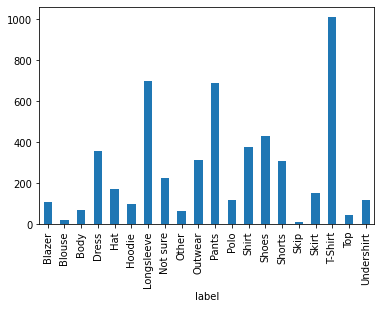

In [5]:
gb_categories['image'].plot.bar()

We can quickly see that the distribution of records per class is not great. Most of the images are for T-shirts and a few in between and some such as skirt have very few records. In order to make a better classifer we need more balanced dataset of images

In [6]:
# lets narrow down number of classes which have relatively high number of records, so when we upscale dataset we'll have a few more examples to build from
gb_categories[gb_categories['image'] > 200]

,image,sender_id,kids
label,,,
Dress,357,357,357
Longsleeve,699,699,699
Not sure,228,228,228
Outwear,312,312,312
Pants,692,692,692
Shirt,378,378,378
Shoes,431,431,431
Shorts,308,308,308
T-Shirt,1011,1011,1011


## Prepairing dataset

In [7]:
# Chose a subset of classes with more data
dict_labels = {'T-Shirt':0, 'Pants':1, 'Longsleeve':2, 'Dress':3, 'Shoes':4}
lookup = {value: key for key, value in dict_labels.items()}

In [8]:
# label encode the class names to prep data for training for tensorflow
dataset = dataset.query(f"label in {[*dict_labels]}")

In [9]:
# taking the X as image and y as label for classification
df_main = dataset[['image','label']]
df_main['y'] = df_main['label'].replace(dict_labels)

C:\Users\Qasim\AppData\Local\Temp/ipykernel_10224/2490017833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['y'] = df_main['label'].replace(dict_labels)


In [10]:
# add image path column next image names, so they are easy to extract into images
df_main['img_path'] = df_main['image'].apply(lambda x: f"../clothing-dataset/images/{x}.jpg")

## Setup Training data in directories for Keras

In [11]:
# # go through dataset and make directory for each class
# for i,r in df_main.iterrows():

#     new_path = f'../clothing-dataset/data/{r["label"]}/{r["image"]+".jpg"}'
#     os.makedirs(os.path.dirname(new_path), exist_ok=True)
#     old_path = r['img_path']

#     # copy to new path
#     shutil.copy(old_path, new_path)

In [12]:
path_images_directory = "../clothing-dataset/data"
# path_images_directory = "C://Users//Qasim//Desktop//dress"


In [13]:
batch_size = 32
img_height = 224
img_width = 224

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path_images_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3230 files belonging to 5 classes.
Using 2584 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path_images_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3230 files belonging to 5 classes.
Using 646 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['Dress', 'Longsleeve', 'Pants', 'Shoes', 'T-Shirt']


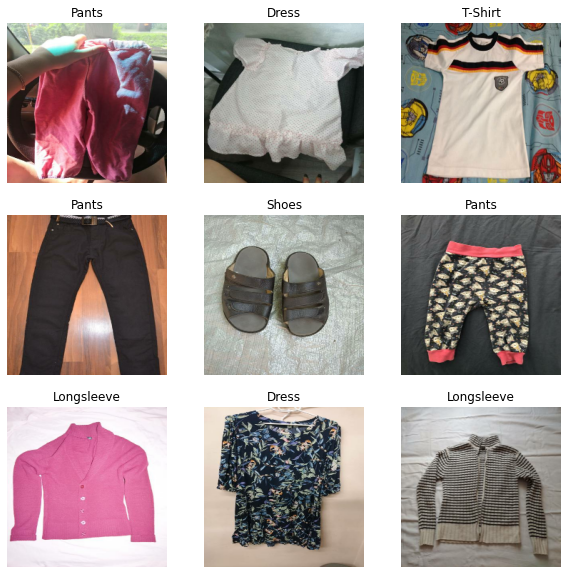

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.90987194


In [22]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

In [25]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
81/81 [==============================] - 6s 27ms/step - loss: 1.3390 - accuracy: 0.4671 - val_loss: 1.0112 - val_accuracy: 0.6455
Epoch 2/10
81/81 [==============================] - 2s 20ms/step - loss: 0.8294 - accuracy: 0.7187 - val_loss: 0.7993 - val_accuracy: 0.7245
Epoch 3/10
81/81 [==============================] - 2s 19ms/step - loss: 0.5564 - accuracy: 0.8146 - val_loss: 0.7092 - val_accuracy: 0.7477
Epoch 4/10
81/81 [==============================] - 2s 19ms/step - loss: 0.3107 - accuracy: 0.8955 - val_loss: 0.6765 - val_accuracy: 0.7802
Epoch 5/10
81/81 [==============================] - 2s 19ms/step - loss: 0.1506 - accuracy: 0.9536 - val_loss: 0.7729 - val_accuracy: 0.7771
Epoch 6/10
81/81 [==============================] - 2s 19ms/step - loss: 0.0758 - accuracy: 0.9803 - val_loss: 0.7818 - val_accuracy: 0.7972
Epoch 7/10
81/81 [==============================] - 2s 19ms/step - loss: 0.0310 - accuracy: 0.9934 - val_loss: 0.9452 - val_accuracy: 0.7957
Epoch 8/10
81

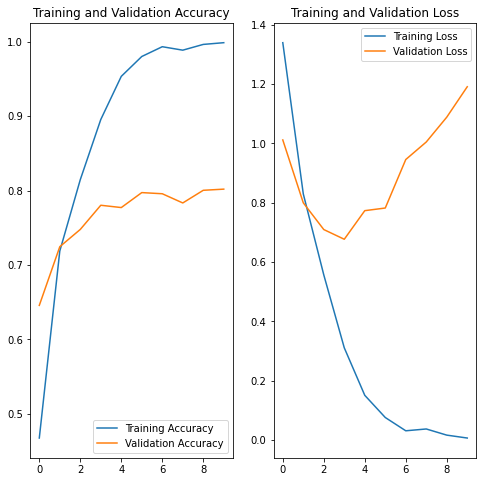

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

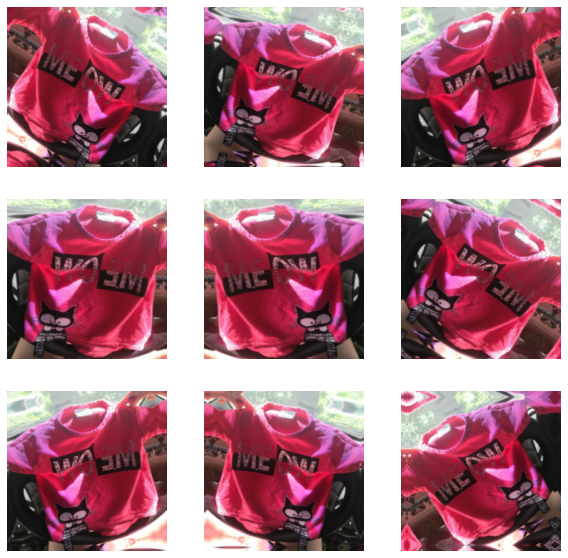

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [29]:
# since dataset is imbalanced set the correct class wieghts
from sklearn.utils import class_weight

train_label = np.concatenate([y for x, y in train_ds], axis=0)

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(train_label),
                                                 y = train_label)

class_weights = dict(zip(np.unique(train_label), class_weights))

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(3,3),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(3,3),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  layers.Dense(num_classes)
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 74, 74, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)       

In [33]:
epochs = 60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weights
)


Epoch 1/60
81/81 [==============================] - 3s 22ms/step - loss: 1.9887 - accuracy: 0.2841 - val_loss: 1.3003 - val_accuracy: 0.4985
Epoch 2/60
81/81 [==============================] - 1s 18ms/step - loss: 1.2658 - accuracy: 0.5325 - val_loss: 1.0914 - val_accuracy: 0.5789
Epoch 3/60
81/81 [==============================] - 2s 19ms/step - loss: 1.1041 - accuracy: 0.6068 - val_loss: 1.0696 - val_accuracy: 0.5759
Epoch 4/60
81/81 [==============================] - 2s 19ms/step - loss: 1.0418 - accuracy: 0.6366 - val_loss: 0.8572 - val_accuracy: 0.7307
Epoch 5/60
81/81 [==============================] - 1s 18ms/step - loss: 0.9888 - accuracy: 0.6583 - val_loss: 0.8120 - val_accuracy: 0.7740
Epoch 6/60
81/81 [==============================] - 1s 18ms/step - loss: 0.9362 - accuracy: 0.6966 - val_loss: 0.8397 - val_accuracy: 0.7508
Epoch 7/60
81/81 [==============================] - 1s 18ms/step - loss: 0.8959 - accuracy: 0.7225 - val_loss: 0.8385 - val_accuracy: 0.7477
Epoch 8/60
81

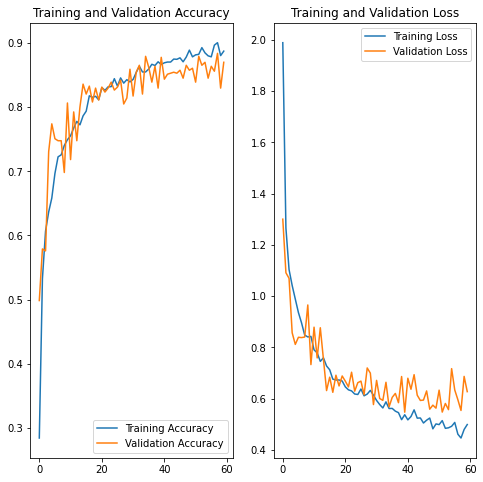

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
# the model is not overfit as there is much tighter fit with training and validation data

In [36]:
model.save("./models/best_model.h5")

In [120]:
model = tf.keras.models.load_model('./models/best_model.h5')

This image most likely belongs to Dress with a 99.98 percent confidence.


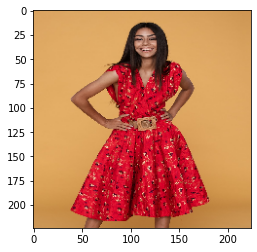

In [122]:

img = tf.keras.utils.load_img(
    '../photo-1572804013309-59a88b7e92f1.jpg', target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [123]:
# model.predict(val_ds)
class_names

['Dress', 'Longsleeve', 'Pants', 'Shoes', 'T-Shirt']

In [39]:
predictions = model.predict(val_ds)
predictions_class = []

In [40]:
for i in predictions:
    predictions_class.append(np.argmax(i))

In [41]:
y_actual= []
for e in val_ds.as_numpy_iterator():
    y_actual.append(e)
y_actual = np.array(y_actual)
y_actual = np.concatenate(y_actual[:,1])

C:\Users\Qasim\AppData\Local\Temp/ipykernel_10224/2281519341.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_actual = np.array(y_actual)


In [42]:
from sklearn.metrics import classification_report

In [43]:
print(classification_report(y_actual, np.array(predictions_class), target_names=class_names))

              precision    recall  f1-score   support

       Dress       0.78      0.71      0.74        75
  Longsleeve       0.81      0.87      0.84       134
       Pants       0.94      0.96      0.95       139
       Shoes       0.97      0.77      0.86        91
     T-Shirt       0.86      0.91      0.88       207

    accuracy                           0.87       646
   macro avg       0.87      0.84      0.85       646
weighted avg       0.87      0.87      0.87       646

